# Building Style Transfer using VGG19



In [33]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19



Style transfer merge the content of the one image with the style of another and create something entirely different image.
* Content image => get the object and arrangement 
* Style image => get the style, colors and textures

In [34]:
# Load the content and style images path
content_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg") #
style_image_path = keras.utils.get_file('starry_night.jpg', "https://i.imgur.com/9ooB60I.jpg")
result_prefix = "paris_generated"


In [35]:
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6  # beta
content_weight = 2.5e-8 # alpa



# Dimension of the generated picture
width, height =load_img(content_image_path).size
img_nrows = 400 # image size you can change it 
img_ncols = int(width * img_nrows / height)

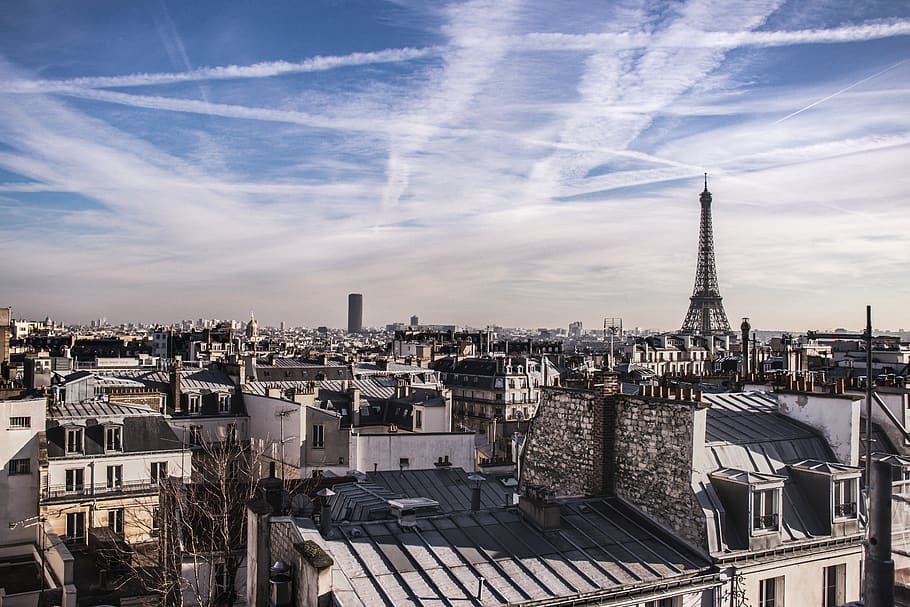

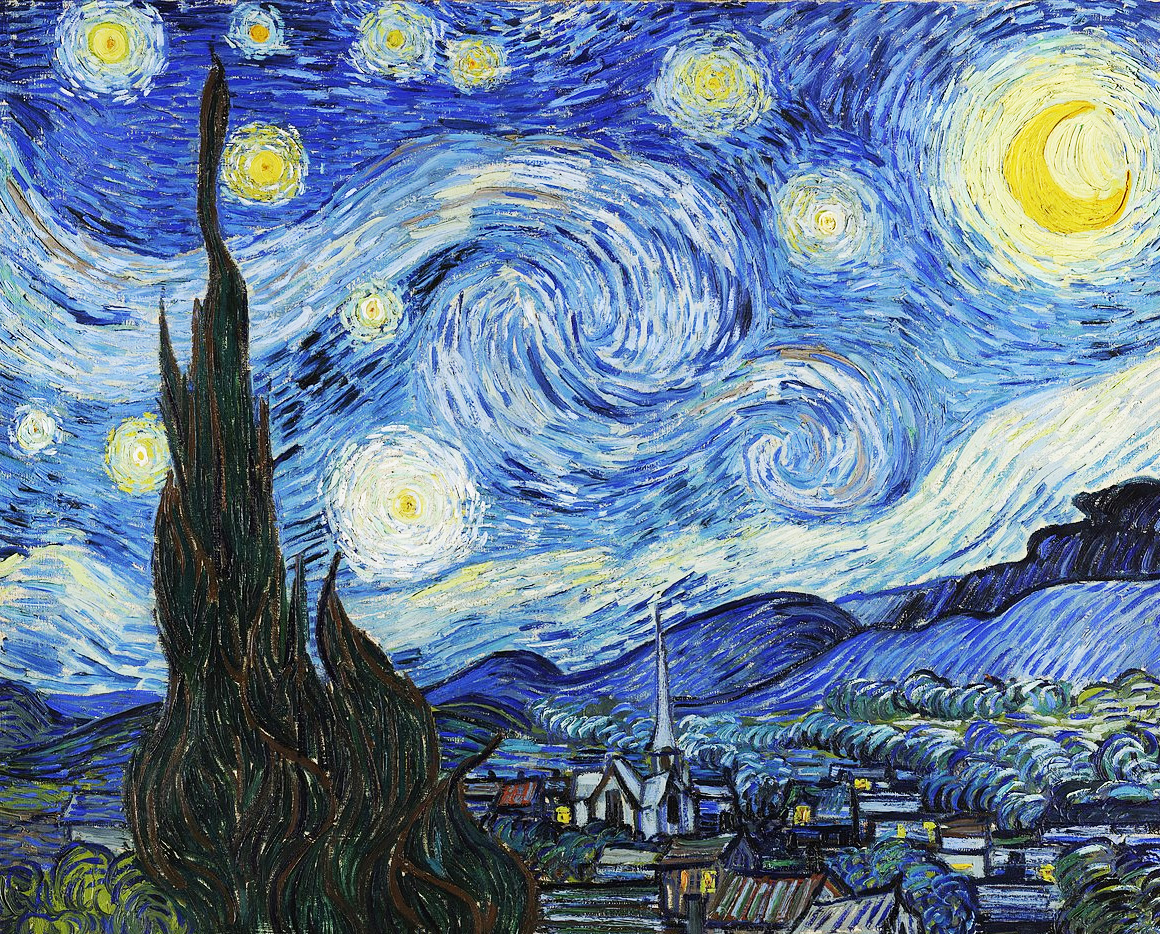

In [36]:
from IPython.display import Image, display
display(Image(content_image_path))
display(Image(style_image_path))

In [37]:
def preprocess_image(image_path):
  """
  Open, resize and format pictures into tensors
  """
  img = load_img(image_path, target_size=(img_nrows, img_ncols))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)

def deprocess_img(x):
  """
  convert a tensor into a valid image
  using the vgg number to normalize
  """
  x = x.reshape((img_nrows, img_ncols, 3))
  # remove zero-center by mean pixel
  x[:,:, 0] += 103.939
  x[:,:, 1] += 116.779
  x[:,:, 2] += 123.68
  # 'BGR' -> 'RGB'
  x = x[:,:, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

## Compute the style loss 


using the Gram matrix 
* style_loss function = is calculates 
* content_loss function = will be the mean squared difference between the target and content feature at layer conv4 (Base image)
* to

In [38]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
  """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
  """
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
  return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
  a = tf.square(
       x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
  )
  b = tf.square(
      x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
  )
  return tf.reduce_sum(tf.pow(a + b, 1.25))

## Building the model 

In [39]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
model.summary()

In [40]:
outputs_dict

{'block1_conv1': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 'block1_conv2': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 'block1_pool': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 'block2_conv1': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 'block2_conv2': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 'block2_pool': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 'block3_conv1': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 'block3_conv2': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 'block3_conv3': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 'block3

In [41]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"

In [42]:
def compute_loss(combination_image, base_image, style_image):
    input_tensor = tf.concat(
        [base_image, style_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [43]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## Training Loop


In [45]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(content_image_path)
style_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(content_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_img(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=11018.25
Iteration 200: loss=8514.23
Iteration 300: loss=7571.63
Iteration 400: loss=7064.05
Iteration 500: loss=6736.28
Iteration 600: loss=6501.71
Iteration 700: loss=6323.17
Iteration 800: loss=6181.47
Iteration 900: loss=6065.42
Iteration 1000: loss=5967.93
Iteration 1100: loss=5884.75
Iteration 1200: loss=5812.89
Iteration 1300: loss=5750.42
Iteration 1400: loss=5695.79
Iteration 1500: loss=5647.28
Iteration 1600: loss=5604.15
Iteration 1700: loss=5565.48
Iteration 1800: loss=5530.65
Iteration 1900: loss=5499.12
Iteration 2000: loss=5470.52
Iteration 2100: loss=5444.41
Iteration 2200: loss=5420.51
Iteration 2300: loss=5398.59
Iteration 2400: loss=5378.42
Iteration 2500: loss=5359.86
Iteration 2600: loss=5342.70
Iteration 2700: loss=5326.80
Iteration 2800: loss=5312.03
Iteration 2900: loss=5298.28
Iteration 3000: loss=5285.47
Iteration 3100: loss=5273.52
Iteration 3200: loss=5262.37
Iteration 3300: loss=5251.95
Iteration 3400: loss=5242.19
Iteration 3500: loss=5

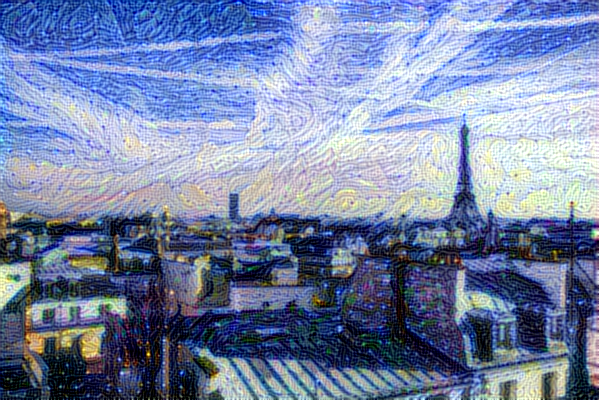

In [46]:
display(Image(result_prefix + "_at_iteration_4000.png"))